## Домашнее задание 2:
В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества - ROC AUC, целевая переменная - isFraud.

Ссылка на данные - https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

In [1]:
# !pip install scikit-plot

In [2]:
from typing import List, Optional
from tqdm import tqdm

import random
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import scikitplot as skplt
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import missingno as msno
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

random.seed(42)

import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [3]:
TRAIN = './assignment_2_train.csv'
TEST = './assignment_2_test.csv'

In [4]:
train = pd.read_csv(TRAIN)
test = pd.read_csv(TEST)
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# train.replace({pd.np.nan: None}, inplace=True)
# test.replace({pd.np.nan: None}, inplace=True)

In [6]:
target_name = 'isFraud'

In [7]:
train.shape, test.shape

((180000, 394), (100001, 394))

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,180000.0,3.077000e+06,5.196167e+04,2987000.000,3031999.75,3076999.5,3121999.25,3166999.00
isFraud,180000.0,2.856111e-02,1.665699e-01,0.000,0.00,0.0,0.00,1.00
TransactionDT,180000.0,1.909818e+06,1.039029e+06,86400.000,1091680.75,1884075.0,2693195.50,3958317.00
TransactionAmt,180000.0,1.295142e+02,2.065150e+02,0.292,44.00,75.0,125.00,5278.95
card1,180000.0,9.860226e+03,4.910778e+03,1001.000,6019.00,9633.0,14182.00,18396.00
...,...,...,...,...,...,...,...,...
V335,47996.0,1.840468e+01,1.208969e+02,0.000,0.00,0.0,0.00,3350.00
V336,47996.0,1.243752e+01,9.930589e+01,0.000,0.00,0.0,0.00,3250.00
V337,47996.0,2.679859e+01,2.526957e+02,0.000,0.00,0.0,0.00,8250.00
V338,47996.0,3.200535e+01,2.848706e+02,0.000,0.00,0.0,0.00,8250.00


In [9]:
X_train = train.drop([target_name, 'TransactionID'], axis=1)
y_train = train[target_name]
X_test = test.drop([target_name, 'TransactionID'], axis=1)
y_test = test[target_name]

In [10]:
features = list(X_train.columns)

In [11]:
# печать гистограмм распределения признаков на трейне и тесте
def hist_features(df_train, df_test=None, cols=5, size=5, bins=None, color_1='blue', color_2='green'):
    n = df_train.shape[1]
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*size, rows*size))
    alpha = 1
    for num, feature in enumerate(df_train.columns):
        ax = axes[num//cols, num%cols] if rows > 1 else axes[num%cols]
        if not df_test is None:
            alpha = 0.3
            data_test = df_test[feature].copy()
            ax.hist(data_test, bins=bins, color=color_2, label='test')
        data_train = df_train[feature].copy()
        ax.hist(data_train, bins=bins, color=color_1, alpha=alpha, label='train')
        ax.set_xlabel(feature, fontsize=14)
        ax.legend()
    plt.show()

### Задание 1:
отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [12]:
numeric_features = []
for feature in features:
    if X_train[feature].unique().shape[0] > 20 and X_train[feature].dtypes != 'object':
        numeric_features.append(feature)
len(numeric_features)

211

In [13]:
# hist_features(X_train[numeric_features])

In [14]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    # "n_estimators": 100,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    # "nthread": 6,
    "seed": 27,
    'predictor': 'gpu_predictor',
    # 'gpu_id': 0,
    'tree_method': 'gpu_hist'
}

In [15]:
d_train = xgb.DMatrix(
    data=X_train[numeric_features], label=y_train
)
d_test = xgb.DMatrix(
    data=X_test[numeric_features], label=y_test
)

In [16]:
model_xgb_num = xgb.train(
    params=params,
    dtrain=d_train,
    num_boost_round=100000,
    early_stopping_rounds=50,
    evals=[(d_train, "train"), (d_test, "test")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.63747	test-auc:0.61859
[20]	train-auc:0.83168	test-auc:0.80493
[40]	train-auc:0.86944	test-auc:0.84678
[60]	train-auc:0.88621	test-auc:0.85269
[80]	train-auc:0.89377	test-auc:0.85337
[100]	train-auc:0.89850	test-auc:0.85457
[120]	train-auc:0.90263	test-auc:0.85583
[140]	train-auc:0.90328	test-auc:0.85641
[160]	train-auc:0.90328	test-auc:0.85641
[172]	train-auc:0.90328	test-auc:0.85641


In [17]:
y_preds = dict()

In [18]:
y_preds['model_xgb_num'] = [round(y) for y in xgb.Booster.predict(model_xgb_num, data=d_test)]

### Задание 2:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1.

In [19]:
def category_encoding(df: pd.Series, bins=None, schema: dict=None, fillNa=0):
    df_copy = df.copy()
    if not fillNa is None:
        df_copy = df_copy.fillna(value=fillNa)
    names = df_copy.value_counts().keys()
    k = len(names) // bins if bins else 1
    if schema is None:
        schema = {value: int(key // k) for key, value in enumerate(names, start=1)}
    for name, i in schema.items():
        df_copy[df_copy == name] = i
    return df_copy, schema

In [20]:
def one_hot_encoding(df: pd.DataFrame, drop_origin_feature=False, schema: list=None):
    df_copy = pd.DataFrame(df)
    for feature in df_copy.columns:
        if schema is None:
            schema = df_copy[feature].value_counts().keys()
        for name in schema:
            new_feature = feature + '_' + name
            df_copy[new_feature] = 0
            df_copy.loc[df_copy[feature] == name, new_feature] = 1
        if drop_origin_feature:
            df_copy.drop(columns=[feature], inplace=True)
    return df_copy, schema

In [21]:
categorical_features = []
for feature in features:
    if X_train[feature].unique().shape[0] <= 20 and X_train[feature].dtypes != 'object':
        categorical_features.append(feature)
len(categorical_features)

167

In [22]:
object_features = X_train.columns[X_train.dtypes == 'object']
object_features

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [23]:
for feature in object_features:
    print(f'{feature}:\n{X_train[feature].value_counts()}\n')

ProductCD:
W    110340
H     22422
R     21926
C     21664
S      3648
Name: ProductCD, dtype: int64

card4:
visa                118295
mastercard           54501
american express      4818
discover              2378
Name: card4, dtype: int64

card6:
debit              122746
credit              57229
debit or credit        10
charge card             8
Name: card6, dtype: int64

P_emaildomain:
gmail.com           67198
yahoo.com           28992
hotmail.com         15058
anonymous.com       13328
aol.com              8583
comcast.net          2916
icloud.com           1677
outlook.com          1484
msn.com              1423
att.net              1223
sbcglobal.net        1092
verizon.net           971
live.com              894
bellsouth.net         713
ymail.com             654
me.com                624
cox.net               570
yahoo.com.mx          522
charter.net           372
optonline.net         362
live.com.mx           254
mac.com               214
rocketmail.com        201
earth

In [24]:
schema_TF = {'F': 0, 'T': 1}
schema_012 = {'M0': 0, 'M1': 1, 'M2': 2}

In [25]:
schemas = dict()

In [26]:
for feature in ['M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9']:
    X_train[feature], schema = category_encoding(X_train[feature], schema=schema_TF)
    X_test[feature] = category_encoding(X_test[feature], schema=schema_TF)[0]
    schemas[feature] = schema

In [27]:
for feature in ['M4']:
    X_train[feature], schema = category_encoding(X_train[feature], schema=schema_012)
    X_test[feature] = category_encoding(X_test[feature], schema=schema_012)[0]
    schemas[feature] = schema

In [28]:
for feature in ['ProductCD', 'card4', 'card6']:
    X_train[feature], schema = category_encoding(X_train[feature])
    X_test[feature] = category_encoding(X_test[feature], schema=schema)[0]
    schemas[feature] = schema

In [29]:
for feature in ['P_emaildomain', 'R_emaildomain']:
    X_train[feature], schema = category_encoding(X_train[feature], bins=5)
    X_test[feature] = category_encoding(X_test[feature], schema=schema)[0]
    schemas[feature] = schema

In [30]:
X_train[categorical_features] = X_train[categorical_features].fillna(0)
X_train[categorical_features] = X_train[categorical_features].astype(np.int)

In [31]:
X_test[categorical_features] = X_test[categorical_features].fillna(0)
X_test[categorical_features] = X_test[categorical_features].astype(np.int)

In [32]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    # "n_estimators": 100,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    # "nthread": 6,
    "seed": 27,
    'predictor': 'gpu_predictor',
    # 'gpu_id': 0,
    'tree_method': 'gpu_hist'
}

In [33]:
d_train = xgb.DMatrix(
    data=X_train[numeric_features + categorical_features], label=y_train, enable_categorical=True
)
d_test = xgb.DMatrix(
    data=X_test[numeric_features + categorical_features], label=y_test, enable_categorical=True
)

In [34]:
model_xgb_num_cat = xgb.train(
    params=params,
    dtrain=d_train,
    num_boost_round=100000,
    early_stopping_rounds=50,
    evals=[(d_train, "train"), (d_test, "test")],
    verbose_eval=20,
    maximize=True,
)

[0]	train-auc:0.64999	test-auc:0.62240
[20]	train-auc:0.81964	test-auc:0.77821
[40]	train-auc:0.87288	test-auc:0.84450
[60]	train-auc:0.88747	test-auc:0.85447
[80]	train-auc:0.89482	test-auc:0.85432
[100]	train-auc:0.89889	test-auc:0.85638
[120]	train-auc:0.90252	test-auc:0.85850
[140]	train-auc:0.90370	test-auc:0.85860
[160]	train-auc:0.90370	test-auc:0.85860
[176]	train-auc:0.90370	test-auc:0.85860


In [35]:
y_preds['model_xgb_num_cat'] = [round(y) for y in xgb.Booster.predict(model_xgb_num_cat, data=d_test)]

### Задание 4:
для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [36]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [37]:
dtrain = lgb.Dataset(
    data=X_train[numeric_features], label=y_train
)
dvalid = lgb.Dataset(
    data=X_test[numeric_features], label=y_test
)

model_lgb_num = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=20000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30359
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.834045	valid_1's auc: 0.800131
[20]	training's auc: 0.838019	valid_1's auc: 0.801834
[30]	training's auc: 0.842062	valid_1's auc: 0.806454
[40]	training's auc: 0.85633	valid_1's auc: 0.829121
[50]	training's auc: 0.858008	valid_1's auc: 0.829712
[60]	training's auc: 0.868769	valid_1's auc: 0.840208
[70]	training's auc: 0.870926	valid_1's auc: 0.84122

In [38]:
y_preds['model_lgb_num'] = [y for y in lgb.Booster.predict(self=model_lgb_num, data=X_test[numeric_features])]

### Задание 5:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 4.

In [39]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [40]:
dtrain = lgb.Dataset(
    data=X_train[numeric_features + categorical_features], label=y_train
)
dvalid = lgb.Dataset(
    data=X_test[numeric_features + categorical_features], label=y_test
)

model_lgb_num_cat = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=20000,
    valid_sets=[dtrain, dvalid],
    categorical_feature=categorical_features,
    early_stopping_rounds=50,
    verbose_eval=10,
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31748
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 377
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.834659	valid_1's auc: 0.799809
[20]	training's auc: 0.838251	valid_1's auc: 0.800175
[30]	training's auc: 0.853352	valid_1's auc: 0.824598
[40]	training's auc: 0.857574	valid_1's auc: 0.828542
[50]	training's auc: 0.859216	valid_1's auc: 0.829353
[60]	training's auc: 0.866457	valid_1's auc: 0.838177
[70]	training's auc: 0.882808	valid_1's auc: 0.8482

In [41]:
y_preds['model_lgb_num_cat'] = [y for y in lgb.Booster.predict(self=model_lgb_num_cat, data=X_test[numeric_features + categorical_features])]

### Задание 6:
обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 4. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 5.

In [42]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27,
}

In [43]:
dtrain = lgb.Dataset(
    data=X_train[numeric_features + categorical_features], label=y_train
)
dvalid = lgb.Dataset(
    data=X_test[numeric_features + categorical_features], label=y_test
)

model_lgb_num_autocat = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=20000,
    valid_sets=[dtrain, dvalid],
    categorical_feature="auto",
    early_stopping_rounds=50,
    verbose_eval=10,
)

[LightGBM] [Info] Number of positive: 5141, number of negative: 174859
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 31786
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 376
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028561 -> initscore=-3.526732
[LightGBM] [Info] Start training from score -3.526732
Training until validation scores don't improve for 50 rounds
[10]	training's auc: 0.833247	valid_1's auc: 0.800062
[20]	training's auc: 0.839511	valid_1's auc: 0.80208
[30]	training's auc: 0.843951	valid_1's auc: 0.807047
[40]	training's auc: 0.858619	valid_1's auc: 0.829908
[50]	training's auc: 0.866867	valid_1's auc: 0.838742
[60]	training's auc: 0.870249	valid_1's auc: 0.841962
[70]	training's auc: 0.885089	valid_1's auc: 0.84986

In [44]:
y_preds['model_lgb_num_autocat'] = [y for y in lgb.Booster.predict(self=model_lgb_num_autocat, data=X_test[numeric_features + categorical_features])]

Автоматический выбор категориальных признаков работает на 10 итераций быстрее (вроде, некритично), мемтрика качества незначительно выше на тестовых данных. В данном случае сходу нельзя определить значимость

### Задание 7:
для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно).

In [45]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [46]:
model_cb_num = cb.CatBoostClassifier(**cb_params)
model_cb_num.fit(
    X=X_train[numeric_features],
    y=y_train,
    eval_set=[(X_train[numeric_features], y_train), (X_test[numeric_features], y_test)],
    # plot=True
)

0:	test: 0.6111265	test1: 0.6143268	best: 0.6143268 (0)	total: 274ms	remaining: 54.5s
10:	test: 0.7777378	test1: 0.7550568	best: 0.7855520 (7)	total: 1.12s	remaining: 19.3s
20:	test: 0.8320160	test1: 0.8204129	best: 0.8204129 (20)	total: 2.03s	remaining: 17.3s
30:	test: 0.8401180	test1: 0.8233431	best: 0.8257581 (29)	total: 2.98s	remaining: 16.3s
40:	test: 0.8422810	test1: 0.8243918	best: 0.8266748 (32)	total: 3.94s	remaining: 15.3s
50:	test: 0.8457915	test1: 0.8253519	best: 0.8266748 (32)	total: 4.95s	remaining: 14.5s
60:	test: 0.8502530	test1: 0.8290832	best: 0.8290832 (60)	total: 5.88s	remaining: 13.4s
70:	test: 0.8546070	test1: 0.8290435	best: 0.8293026 (62)	total: 6.82s	remaining: 12.4s
80:	test: 0.8578187	test1: 0.8356565	best: 0.8356565 (80)	total: 7.79s	remaining: 11.4s
90:	test: 0.8633440	test1: 0.8390432	best: 0.8390432 (90)	total: 8.79s	remaining: 10.5s
100:	test: 0.8644712	test1: 0.8399033	best: 0.8401368 (98)	total: 9.72s	remaining: 9.53s
110:	test: 0.8666058	test1: 0.8400

In [47]:
y_preds['model_cb_num'] = [y for y in model_cb_num.predict(X_test[numeric_features])]

### Задание 8:
обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 7.

In [48]:
cb_params = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 50,
    "thread_count": 6,
    "random_seed": 42
}

In [49]:
model_cb_num_cat = cb.CatBoostClassifier(**cb_params)
model_cb_num_cat.fit(
    X=X_train[numeric_features + categorical_features],
    y=y_train,
    eval_set=[(X_train[numeric_features + categorical_features], y_train), (X_test[numeric_features + categorical_features], y_test)],
    # plot=True
)

0:	test: 0.6127567	test1: 0.5969901	best: 0.5969901 (0)	total: 100ms	remaining: 19.9s
10:	test: 0.7865235	test1: 0.7720262	best: 0.7720262 (10)	total: 1.1s	remaining: 19s
20:	test: 0.8232765	test1: 0.8117117	best: 0.8117117 (20)	total: 2.12s	remaining: 18s
30:	test: 0.8376778	test1: 0.8202867	best: 0.8202867 (30)	total: 3.17s	remaining: 17.3s
40:	test: 0.8449999	test1: 0.8260454	best: 0.8263286 (36)	total: 4.27s	remaining: 16.6s
50:	test: 0.8471215	test1: 0.8249923	best: 0.8263286 (36)	total: 5.35s	remaining: 15.6s
60:	test: 0.8498744	test1: 0.8259142	best: 0.8264199 (55)	total: 6.47s	remaining: 14.7s
70:	test: 0.8564562	test1: 0.8353688	best: 0.8353688 (70)	total: 7.58s	remaining: 13.8s
80:	test: 0.8595182	test1: 0.8364016	best: 0.8364016 (80)	total: 8.7s	remaining: 12.8s
90:	test: 0.8605792	test1: 0.8365382	best: 0.8365382 (90)	total: 9.82s	remaining: 11.8s
100:	test: 0.8621863	test1: 0.8341441	best: 0.8365382 (90)	total: 10.9s	remaining: 10.7s
110:	test: 0.8648047	test1: 0.8374510	b

In [50]:
y_preds['model_cb_num_cat'] = [y for y in model_cb_num_cat.predict(X_test[numeric_features + categorical_features])]

### Задание 9:
обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 7. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 8.

In [51]:
model_cb_num_autocat = cb.CatBoostClassifier(**cb_params)
model_cb_num_autocat.fit(
    X=X_train[numeric_features + categorical_features],
    y=y_train,
    eval_set=[(X_train[numeric_features + categorical_features], y_train), (X_test[numeric_features + categorical_features], y_test)],
    cat_features=np.array(categorical_features),
    # plot=True
)

0:	test: 0.6346323	test1: 0.6339733	best: 0.6339733 (0)	total: 7.5s	remaining: 24m 52s
10:	test: 0.7846728	test1: 0.7832422	best: 0.7832422 (10)	total: 1m 15s	remaining: 21m 33s
20:	test: 0.8208650	test1: 0.8192721	best: 0.8192721 (20)	total: 2m 9s	remaining: 18m 27s
30:	test: 0.8323154	test1: 0.8154623	best: 0.8192721 (20)	total: 3m 5s	remaining: 16m 48s
40:	test: 0.8422870	test1: 0.8212951	best: 0.8212951 (40)	total: 3m 59s	remaining: 15m 28s
50:	test: 0.8486385	test1: 0.8302546	best: 0.8318221 (47)	total: 4m 51s	remaining: 14m 11s
60:	test: 0.8498967	test1: 0.8295133	best: 0.8318221 (47)	total: 5m 44s	remaining: 13m 4s
70:	test: 0.8517913	test1: 0.8301429	best: 0.8318221 (47)	total: 6m 33s	remaining: 11m 54s
80:	test: 0.8528555	test1: 0.8303454	best: 0.8318221 (47)	total: 7m 25s	remaining: 10m 53s
90:	test: 0.8541824	test1: 0.8314469	best: 0.8318221 (47)	total: 8m 15s	remaining: 9m 53s
100:	test: 0.8630853	test1: 0.8394603	best: 0.8394603 (100)	total: 9m 5s	remaining: 8m 54s
110:	te

In [52]:
y_preds['model_cb_num_autocat'] = [y for y in model_cb_num_autocat.predict(X_test[numeric_features + categorical_features])]

это было очень долго, а результат почти тот же

### Задание 10:
построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения.

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

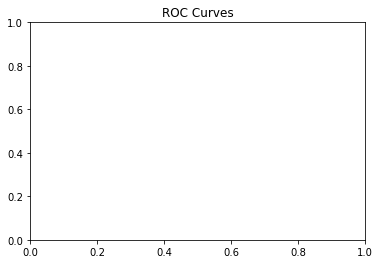

In [53]:
skplt.metrics.plot_roc(y_test, y_preds.values())
plt.show()

In [ ]:
такой вариант не прошел, нужно, нав

## Задание на повторение:
Задание не обязательно к выполнению, но очень рекомендуется для понимания набора данных, этот набор данных будет использован и для следующего домашнего задания.

### Задание 1:
Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.

### Задание 2:
построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

### Задание 3:
построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

### Задание 4:
построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.